# 1. Đọc dataframe

In [94]:
import os
import json
import pandas as pd

folder_paths = {
    'C:/Users/VivoBook/Documents/detect fake news/VFND-vietnamese-fake-news-datasets/Dataset/Fake/Article_Contents': 'Fake',
    'C:/Users/VivoBook/Documents/detect fake news/VFND-vietnamese-fake-news-datasets/Dataset/Real/Article_Contents': 'Real'
    }

dfs = [] 

for folder_path, label in folder_paths.items():
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]  # Lọc file JSON

    for file in json_files:
        file_path = os.path.join(folder_path, file)  # Đường dẫn file JSON
        
        try:
            # Đọc file JSON
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)

            # Nếu JSON là dictionary thay vì danh sách, chuyển thành danh sách
            if isinstance(data, dict):
                data = [data]

            # Chuyển đổi thành DataFrame
            df = pd.DataFrame(data)

            # Kiểm tra nếu DataFrame không có dòng nào
            if df.shape[0] == 0:
                print(f"File {file} không có dữ liệu.")
                continue

            # Trích xuất ID từ tên file (Fake_68, Real_15, ...)
            file_parts = file.split("_")  # Tách chuỗi theo dấu "_"
            file_id = "_".join(file_parts[-2:]).replace(".json", "")  # Lấy phần cuối của tên file
            
            # Thống nhất maintext và text thành maintext
            if "text" in df.columns:
                df.rename(columns={"text": "maintext"}, inplace=True)
            if "maintext" not in df.columns:  
                df["maintext"] = ""  # Nếu không có cả 2, đặt giá trị rỗng

            # Kiểm tra và xử lý cột "authors"
            if "authors" in df.columns:
                df["authors"] = df["authors"].apply(lambda x: ", ".join(x) if isinstance(x, list) and len(x) > 0 else "")

            # Thêm cột ID và target (Fake/Real)
            df['id'] = file_id  
            df['target'] = label  

            dfs.append(df)

        except Exception as e:
            print(f"Lỗi khi đọc file {file}: {e}")

# Gộp tất cả DataFrame lại (giữ tất cả cột)
df = pd.concat(dfs, ignore_index=True, join='outer')

# Điền giá trị trống bằng chuỗi rỗng
df = df.fillna('')

# Reset index
df.reset_index(drop=True, inplace=True)


In [95]:
df = df[['id', 'authors', 'source_domain', 'language', 'title', 'description', 'maintext', 'target']]
df.reset_index(drop=True, inplace=True)
df.head()

,id,authors,source_domain,language,title,description,maintext,target
0,Fake_0,,2sao.vn,vi,Con gái chính là người tình kiếp trước của cha...,Tình phụ tử: Cách yêu thương của cha giành cho...,"Thế nhưng, dù không nói ra thì cha vĩnh viễn l...",Fake
1,Fake_1,Văn Trình,binhluan.biz,en,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,,"Theo Sankei Sports, sáng nay Thủ tướng Nhật Bả...",Fake
2,Fake_10,,suckhoe.vnexpress.net,vi,Bức vẽ giúp bạn đánh giá mức độ stress của bản...,Bức vẽ gồm một hình cầu dường như đang trượt m...,"Nhìn bức tranh, bạn có thể thấy vòng tròn đang...",Fake
3,Fake_100,,www.vietgiaitri.com,vi,YÊU RÂU XANH (P51): Câu chuyện động trời sau t...,"Đúng lúc đó, một người hàng xóm nhà bà H sang ...","Sau khi vụ án xảy ra, tất cả mọi người đều khô...",Fake
4,Fake_101,,mangxahoi.net,vi,"NÓNG : xử phạt 10 đối tượng ""bom"" hàng "" Lợi d...",,"ĐANG RẤT QUÁ TẢI, MONG MỌI NGƯỜI Ý THỨC! NGƯỜI...",Fake


In [96]:
df.shape

(260, 8)

# 2. Tiền xử lí dữ liệu

In [97]:
df.describe()

,id,authors,source_domain,language,title,description,maintext,target
count,260,260,260,260,260,260,260,260
unique,260,32,54,3,258,226,259,2
top,Fake_0,,vnexpress.net,vi,Những dấu hiệu nhận biết nhà bạn đang có ma và...,,Những dấu hiệu nhận biết nhà có ma đơn giản nh...,Fake
freq,1,209,74,233,2,34,2,132


Thuộc tính Language có quá ít giá trị (vi, en, rỗng) so với các thuộc tính khác, vì vậy language sẽ không đóng vai trò nhiều trong decision tree.

In [98]:
# Kiểm tra duplicates
df[df.duplicated(subset=df.columns.difference(['id']), keep=False)]


,id,authors,source_domain,language,title,description,maintext,target
69,Fake_42,,tinvn.info,vi,Những dấu hiệu nhận biết nhà bạn đang có ma và...,Những dấu hiệu nhận biết nhà bạn đang có ma và...,Những dấu hiệu nhận biết nhà có ma đơn giản nh...,Fake
105,Fake_75,,tinvn.info,vi,Những dấu hiệu nhận biết nhà bạn đang có ma và...,Những dấu hiệu nhận biết nhà bạn đang có ma và...,Những dấu hiệu nhận biết nhà có ma đơn giản nh...,Fake


In [99]:
df.drop(index=105, inplace=True)  # Xóa dòng có index = 105
df.reset_index(drop=True, inplace=True)  # Reset index, bỏ index cũ


In [100]:
df['target'].value_counts()  # Tỉ lệ giữa Fake và Real xấp xỉ nhau nên dataset này đã cân bằng (balance)

target
Fake    131
Real    128
Name: count, dtype: int64

# 3. Tìm rule-based system 

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Thiết kế mô hình cho Decision tree theo tiêu chuẩn entropy
def model_tree(depth):
    model = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42) 
    return model


# Tính accuracy của Decision tree
def calculate_acc(dataframe, x_features, y_feature, model=model_tree):  
    # Gán X là tập các biến độc lập và y là biến phụ thuộc (biến dự đoán)    
    X = x_features
    y = dataframe[y_feature].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Lấy 80% - 20% dataset để train - test

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Tính acc
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return f"Accuracy của Decision Tree: {accuracy:.2%}"


# Biểu diễn Tree
def plot_decision_tree(model, x_features):
    plt.figure(figsize=(12, 8))
    plot_tree(model, feature_names=x_features, class_names=["Fake", "Real"], filled=True)
    plt.show()


## 3.1 Tìm RB dựa trên `source_domain` và `authors`

In [102]:
df1 = df[['authors', 'source_domain', 'target']]
df1.shape

(259, 3)

In [103]:
# Chuyển đổi 'source_domain' và 'authors' thành số (dùng LabelEncoder)
from sklearn.preprocessing import LabelEncoder

encoder_source = LabelEncoder()
encoder_authors = LabelEncoder()

df1["source_domain_encoded"] = encoder_source.fit_transform(df1["source_domain"])
df1["authors_encoded"] = encoder_authors.fit_transform(df1["authors"])


C:\Users\VivoBook\AppData\Local\Temp\ipykernel_10136\1272835352.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["source_domain_encoded"] = encoder_source.fit_transform(df1["source_domain"])
C:\Users\VivoBook\AppData\Local\Temp\ipykernel_10136\1272835352.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["authors_encoded"] = encoder_authors.fit_transform(df1["authors"])


Accuracy của Decision Tree: 90.38%


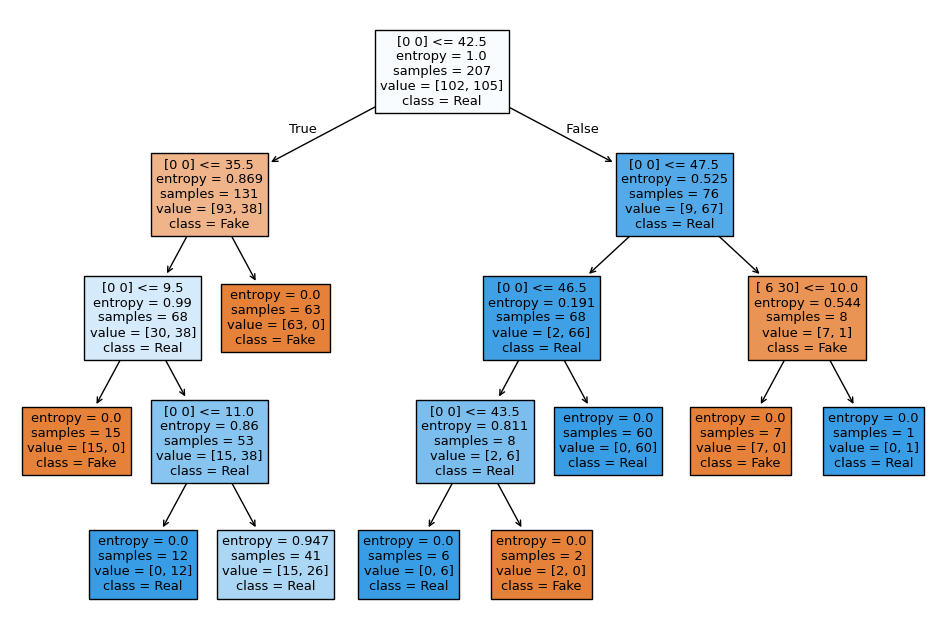

None


In [113]:
tree_model1 = model_tree(depth=4)

X_le = np.hstack([df1["source_domain_encoded"].values.reshape(-1, 1),
                  df1["authors_encoded"].values.reshape(-1, 1)])

print(calculate_acc(df1, X_le, 'target', model=tree_model1))
print(plot_decision_tree(tree_model1, X_le))


In [105]:
# Tạo bảng mapping cho source_domain
df_mapping_source = pd.DataFrame({"source_domain_encoded": df1["source_domain_encoded"],
                                  "source_domain_original": df["source_domain"]}
                                  ).drop_duplicates().sort_values(by="source_domain_encoded", ascending=True)
df_mapping_source


,source_domain_encoded,source_domain_original
0,0,2sao.vn
5,1,anninh247.xyz
35,2,autoxe.net
43,3,baoangiang.com.vn
52,4,baonuocmy.com
11,5,baophapluat.online
1,6,binhluan.biz
29,7,blogxcy.wordpress.com
6,8,cand.com.vn
36,9,congtintuc24gio.com


In [110]:
df[df['source_domain'].str.contains('giadinhtiepthi.com', case=False, na=False)]


,id,authors,source_domain,language,title,description,maintext,target
88,Fake_6,Please Enter Your Name Here,giadinhtiepthi.com,vi,"Cười vỡ bụng khi tiếng CẢI CÁCH ""vuông tròn"" x...",,"Những ngày qua, các phụ huynh liên tục chia sẻ...",Fake
99,Fake_7,Please Enter Your Name Here,giadinhtiepthi.com,vi,Chia sẻ thẳng thắn vụ việc 25000 USD và cải cá...,,"Những ngày qua, trên mạng xã hội các phụ huynh...",Fake


In [14]:
# Tạo bảng mapping cho authors
df_mapping_authors = pd.DataFrame({"authors_encoded": df1["authors_encoded"], 
                                   "authors_original": df["authors"]}
                                   ).drop_duplicates().sort_values(by="authors_encoded", ascending=True)
df_mapping_authors


,authors_encoded,authors_original
0,0,
171,1,An Bình
173,2,CÔNG TRUNG
42,3,Cùng Tác Giả
44,4,"Cùng Tác Giả, Nguyễn Thiện"
172,5,D.KIM THOA
77,6,Gioi Tre Viet
182,7,Hiếu Công
40,8,"Hoàng Vy Thế Giới Trẻ, - Phuong Thao -, - Dung..."
132,9,Hạ Huyền


## 3.2 Tìm RB dựa trên `title`

In [15]:
df2 = df[['title', 'target']]
df2.shape


(259, 2)

In [16]:
# Đọc danh sách n-grams từ file
def read_ngrams(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f.readlines()]

# Đọc danh sách n-gram từ 3 file
bi_grams = read_ngrams("C:/Users/VivoBook/Documents/detect fake news/VFND-vietnamese-fake-news-datasets/Dictionaries/bi_gram.txt")
tri_grams = read_ngrams("C:/Users/VivoBook/Documents/detect fake news/VFND-vietnamese-fake-news-datasets/Dictionaries/tri_gram.txt")
four_grams = read_ngrams("C:/Users/VivoBook/Documents/detect fake news/VFND-vietnamese-fake-news-datasets/Dictionaries/four_gram.txt")

# Tổng hợp danh sách tất cả n-grams
all_ngrams = set(bi_grams + tri_grams + four_grams)

print("Số lượng n-grams:", len(all_ngrams))


Số lượng n-grams: 44800


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Lấy dữ liệu tiêu đề
titles = df2["title"].astype(str).tolist()

# Khởi tạo TfidfVectorizer với danh sách n-grams từ file
vectorizer = TfidfVectorizer(ngram_range=(2, 4), vocabulary=all_ngrams)

# Tính toán TF-IDF
X_tfidf = vectorizer.fit_transform(titles)

# Lấy danh sách từ đặc trưng 
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = np.array(X_tfidf.mean(axis=0)).flatten()

# Chuyển thành DataFrame và xếp trọng số TF-IDF giảm dần
df2_tfidf = pd.DataFrame({'N-gram': feature_names, 'TF-IDF Score': tfidf_scores}).sort_values(by="TF-IDF Score", ascending=False)

# Hiển thị danh sách n-gram và trọng số của chúng
df2_tfidf.head(12)


c:\Users\VivoBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:1368: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


,N-gram,TF-IDF Score
41715,đàn ông,0.020670
29536,sự thật,0.019388
19809,máy bay,0.015833
6173,con gái,0.014489
25289,phát hiện,0.013462
35330,tài xế,0.013058
7047,có thể,0.012658
39717,xã hội,0.012587
1684,báo mộng,0.011783
16058,kinh hoàng,0.010419


In [88]:
# Chọn 10 n-gram có trọng số cao nhất
top_ngrams = df2_tfidf.nlargest(300, 'TF-IDF Score')["N-gram"].tolist()


# Tạo feature matrix từ df2['title']
vectorizer_top = TfidfVectorizer(ngram_range=(2, 4), vocabulary=top_ngrams)
# Vector hóa dữ liệu
X_tfidf_top = vectorizer_top.fit_transform(df2["title"]).toarray()


tree_model2 = model_tree(depth=50)
print(calculate_acc(df2, X_tfidf_top, 'target', model=tree_model2))
# print(plot_decision_tree(tree_model2, vectorizer_top.get_feature_names_out()))
print(export_text(tree_model2, feature_names=vectorizer_top.get_feature_names_out()))

Accuracy của Decision Tree: 75.00%
|--- sự thật <= 0.17
|   |--- con gái <= 0.22
|   |   |--- kinh dị <= 0.25
|   |   |   |--- tài xế <= 0.24
|   |   |   |   |--- bí mật <= 0.25
|   |   |   |   |   |--- đàn ông <= 0.43
|   |   |   |   |   |   |--- tất cả <= 0.18
|   |   |   |   |   |   |   |--- báo mộng <= 0.25
|   |   |   |   |   |   |   |   |--- lý do <= 0.26
|   |   |   |   |   |   |   |   |   |--- cải cách <= 0.28
|   |   |   |   |   |   |   |   |   |   |--- cảnh tượng <= 0.20
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 40
|   |   |   |   |   |   |   |   |   |   |--- cảnh tượng >  0.20
|   |   |   |   |   |   |   |   |   |   |   |--- class: Fake
|   |   |   |   |   |   |   |   |   |--- cải cách >  0.28
|   |   |   |   |   |   |   |   |   |   |--- class: Fake
|   |   |   |   |   |   |   |   |--- lý do >  0.26
|   |   |   |   |   |   |   |   |   |--- class: Fake
|   |   |   |   |   |   |   |--- báo mộng >  0.25
|   |   |   |   |   |   |   |   |--- class

# 4. Tổng hợp rule-based system

In [114]:
import string
import math  

def rule_based_classification(source, author, text_title):
    # Danh sách nguồn tin giả mạo
    fake_sources = {
        '2sao.vn', 'anninh247.xyz', 'autoxe.net', 'baoangiang.com.vn', 'baonuocmy.com', 
        'baophapluat.online', 'binhluan.biz', 'blogxcy.wordpress.com', 'cand.com.vn', 'congtintuc24gio.com',
        'thoibao.de', 'thoibao.today', 'tingame.info', 'tintuconline.com.vn', 'tintucqpvn.net', 
        'tinvn.info', 'trumpandq.blogspot.com', 'tuvanannam.com', 'vietgiaitri.com', 'vinaexpress.com.vn'}

    # Danh sách tác giả đáng ngờ (chỉ cần chứa một trong số các từ này)
    fake_author_keywords = {'An Bình', 'CÔNG TRUNG', 'Cùng Tác Giả', 'D.KIM THOA', 'Gioi Tre Viet',
                            'Hiếu Công', 'Hoàng Vy Thế Giới Trẻ', 'Hạ Huyền', 'J', 'Daisy'}
  
    # Từ khóa và ngưỡng TF-IDF
    keywords = {'sự thật': 0.17,
                'con gái': 0.22,
                'kinh dị': 0.25,
                'tài xế': 0.24,
                'bí mật': 0.25,
                'đàn ông': 0.43,
                'tất cả': 0.18,
                'báo mộng': 0.25,
                'lý do': 0.26,
                'cải cách': 0.28,
                'cảnh tượng': 0.20}
    
    # Danh sách dấu câu cần kiểm tra (loại bỏ dấu chấm `.` và dấu phẩy `,`)
    punctuation_to_check = set(string.punctuation) - {'.', ','}
    
    # Rule 1: Xác định tỷ lệ Fake dựa vào source và author
    fake_source = source in fake_sources
    fake_author = any(keyword in author for keyword in fake_author_keywords) 

    if fake_source and fake_author:
        fake_score_source_author = 1 * 0.9  # Fake cả source và author
    elif fake_source or fake_author:
        fake_score_source_author = 0.5 * 0.9  # Fake ở source hoặc author
    else:
        fake_score_source_author = 0  # Không Fake ở cả hai
    
    # Rule 2: Tính toán TF-IDF để kiểm tra từ khóa
    vectorizer = TfidfVectorizer(vocabulary=keywords.keys())  # Chỉ tính TF-IDF cho từ khóa
    tfidf_matrix = vectorizer.fit_transform([text_title])
    
    fake_score_keywords = 0
    count_violations = 0
    
    feature_names = vectorizer.get_feature_names_out()
    for idx, word in enumerate(feature_names):
        if tfidf_matrix[0, idx] > keywords[word]:  # Nếu trọng số TF-IDF vượt ngưỡng
            count_violations += 1  

    # Kiểm tra dấu câu trực tiếp trong text_title
    count_punctuation_violations = sum(1 for p in punctuation_to_check if p in text_title)
    count_violations += count_punctuation_violations 
    
    # Tính điểm Fake dựa vào số lần vi phạm
    if count_violations > 0:
        fake_score_keywords = 1 - math.pow(0.71, count_violations)  
    
    # Tính tỷ lệ Fake/Real từ source/author và keywords
    fake_score = fake_score_source_author + fake_score_keywords
    real_score = 1 - fake_score

    return {'fake_score': round(fake_score, 2), 'real_score': round(real_score, 2) }


In [116]:
# Kiểm tra lại
source = 'thoibao.today'
author = ''
text_title = 'Khám phá sửng sốt về trí nhớ \"như thần\" của động vật' 

result = rule_based_classification(source, author, text_title)
result
# result['fake_score']  # Chỉ in Fake_score

{'fake_score': 0.74, 'real_score': 0.26}